In [66]:

import requests
import pandas
import json
from pprint import pp

url= 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'

response= requests.get(url)

r= response.json()


In [67]:
print(response)

<Response [200]>


In [68]:
print(r)

[{'Application_ID': 'LP001002', 'Gender': 'Male', 'Married': 'No', 'Dependents': '0', 'Education': 'Graduate', 'Self_Employed': 'No', 'Credit_History': 1, 'Property_Area': 'Urban', 'Income': 'medium', 'Application_Status': 'Y'}, {'Application_ID': 'LP001003', 'Gender': 'Male', 'Married': 'Yes', 'Dependents': '1', 'Education': 'Graduate', 'Self_Employed': 'No', 'Credit_History': 1, 'Property_Area': 'Rural', 'Income': 'medium', 'Application_Status': 'N'}, {'Application_ID': 'LP001005', 'Gender': 'Male', 'Married': 'Yes', 'Dependents': '0', 'Education': 'Graduate', 'Self_Employed': 'Yes', 'Credit_History': 1, 'Property_Area': 'Urban', 'Income': 'low', 'Application_Status': 'Y'}, {'Application_ID': 'LP001006', 'Gender': 'Male', 'Married': 'Yes', 'Dependents': '0', 'Education': 'Not Graduate', 'Self_Employed': 'No', 'Credit_History': 1, 'Property_Area': 'Urban', 'Income': 'low', 'Application_Status': 'Y'}, {'Application_ID': 'LP001008', 'Gender': 'Male', 'Married': 'No', 'Dependents': '0', 

In [69]:
print(r[0])

{'Application_ID': 'LP001002', 'Gender': 'Male', 'Married': 'No', 'Dependents': '0', 'Education': 'Graduate', 'Self_Employed': 'No', 'Credit_History': 1, 'Property_Area': 'Urban', 'Income': 'medium', 'Application_Status': 'Y'}


In [70]:
import pandas as pd
df_loan= pd.DataFrame(r)

In [71]:
df_loan.shape

(511, 10)

In [72]:
df_loan

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y
...,...,...,...,...,...,...,...,...,...,...
506,LP002978,Female,No,0,Graduate,No,1,Rural,low,Y
507,LP002979,Male,Yes,3+,Graduate,No,1,Rural,medium,Y
508,LP002983,Male,Yes,1,Graduate,No,1,Urban,medium,Y
509,LP002984,Male,Yes,2,Graduate,No,1,Urban,medium,Y


In [73]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import*

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType

In [74]:
spark = SparkSession.builder.appName('loaninfo').getOrCreate()

In [75]:
spdf_loan=spark.createDataFrame(df_loan)

c:\Spark\python\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
c:\Spark\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [76]:
spdf_loan.show()

+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001002|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|
|      LP001003|  Male|    Yes|         1|    Graduate|           No|             1|        Rural|medium|                 N|
|      LP001005|  Male|    Yes|         0|    Graduate|          Yes|             1|        Urban|   low|                 Y|
|      LP001006|  Male|    Yes|         0|Not Graduate|           No|             1|        Urban|   low|                 Y|
|      LP001008|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|


In [77]:
spdf_loan.printSchema()

root
 |-- Application_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Application_Status: string (nullable = true)



In [78]:
spdf_loan.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

               


In [83]:
query = "(SELECT self_employed, \
                (round(count(application_status)/(SELECT COUNT(Application_ID) FROM cdw_sapp_loan_application \
                WHERE application_status = 'Y')*100, 2) ) as Percent \
                FROM cdw_sapp_loan_application \
                WHERE Application_status = 'Y' \
                GROUP BY self_employed, application_status) as b"

sp_sql1 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query) \
  .load()

sp_sql1.show()


+-------------+-------+
|self_employed|Percent|
+-------------+-------+
|           No|  86.74|
|          Yes|  13.26|
+-------------+-------+



In [ ]:
'''df_new = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_loan_application") \
  .option("user", "root") \
  .option("password", "password") \
  .load()

df_new.show()'''


In [ ]:
'''df_new.createTempView("CDW_SAPP_loan_application")  # deal will use as a table name
spark.sql("SELECT * from CDW_SAPP_loan_application").show(4)'''

In [84]:
sploanDF=sp_sql1.toPandas()
#df=df_new1.toPandas()
sploanDF.tail()


,self_employed,Percent
0,No,86.74
1,Yes,13.26


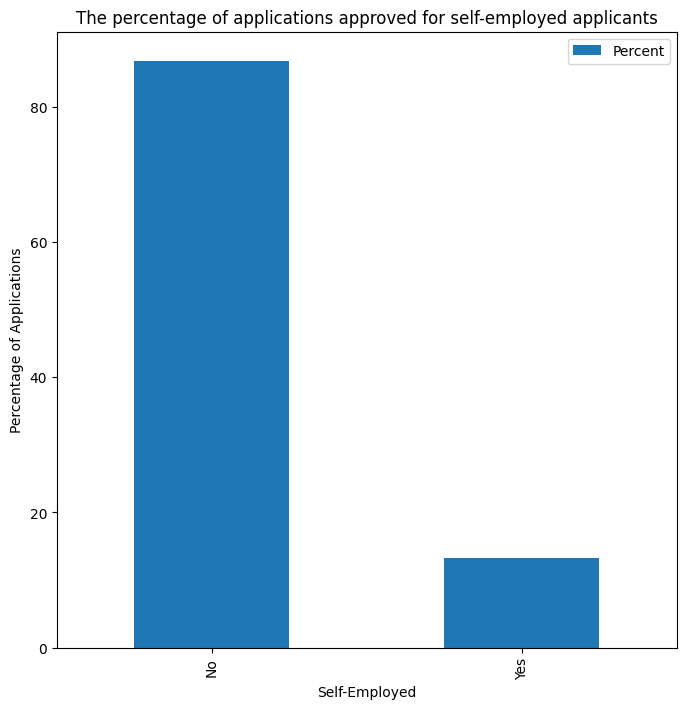

In [85]:
# import pandas as pd
import matplotlib.pyplot as plt



# pd_sql1.reset_index(inplace=True)
sploanDF['Percent'] = sploanDF['Percent'].astype('float')

sploanDF.plot(kind='bar', x='self_employed', y='Percent', figsize=(8,8))
plt.title('The percentage of applications approved for self-employed applicants')
plt.xlabel('Self-Employed')
plt.ylabel('Percentage of Applications')
plt.show()
